# Colored MNIST (Temping to put more value on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [26]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets.utils as dataset_utils
from torch.autograd import grad
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torchvision import __version__ as torchvision_version

In [27]:
# include plots in notebook
%matplotlib inline

In [28]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Tue Nov  1 17:35:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   36C    P0    93W / 350W |   2385MiB / 32510MiB |     80%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

In [29]:
def color_grayscale_arr(arr, green=True):
  """
  Convert grayscale MNIST images to either red or green MNIST images by expanding
  the image to three RGB dimensions. The grayscale image either gets applied to
  the red or green channel.
  """
  assert arr.ndim == 2
  
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  
  if green:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)],axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Downloads the grayscale MNIST dataset and transforms it into a colored MNIST dataset.
  Digits smaller than 5 are colored red for the train and validation set. Numbers larger
  than 5 are colored green for the train and validation set. The colors of the digits have
  a 50% probability to be flipped.
  """
  def __init__(self, root='./data', env='train', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train', 'val', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train, val and test')

  def __getitem__(self, index):
    """
    Overriden method from datasets.VisionDataset to apply transformations to the data
    before providing them to the dataloader.
    """
    img, asdf, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, asdf, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    """
    Download 60'000 grayscale MNIST images, split them into a train, validation and a test
    dataset and transform them to a colored MNIST dataset.
    """
    
    def mnist_grayscale_to_color():
      def conversion_progress(idx, datasource, phase='train'):
        if idx % 5000 == 0:
            print(f'Converting {phase} image {idx}/{len(datasource)}')
      
      # http://yann.lecun.com/exdb/mnist/
      print('Preparing Colored MNIST')
      train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True) # 60'000 samples for training
      test_mnist = datasets.mnist.MNIST(self.root, train=False, download=True) # 10'000 samples for validation and test

      train_set = []
      validation_set = []
      test_set = []
      
      for dataset in ['train_ds', 'test_ds']:
        datasource = train_mnist if (dataset == 'train_ds') else test_mnist

        for idx, (im, label) in enumerate(datasource):
          # determine train, validation, test phase/split
          if dataset == 'train_ds':
            phase = 'train'
          elif dataset == 'test_ds':
            if idx < len(datasource)//2:
              phase = 'validation'
            else:
              phase = 'test'
          
          # progress bar
          conversion_progress(idx, datasource, phase)
                
          # Assign binary digit label for small and large numbers
          true_label = 1 if label > 4 else 0

          # Assign random color labels to test set
          if phase == 'test':
            color_label = true_label if np.random.rand() < .5 else true_label^1
          else:
            color_label = true_label
          
          # Color the digit
          colored_arr = color_grayscale_arr(np.array(im), green=color_label)
          
          # create dataset with image, true_label (1 for high numbers, 0 for low numbers) and color_label (potentially mixed up label for test dataset)
          if phase == 'train':
            train_set.append((Image.fromarray(colored_arr), true_label, color_label))
          elif phase == 'validation':
            validation_set.append((Image.fromarray(colored_arr), true_label, color_label))
          else:
            test_set.append((Image.fromarray(colored_arr), true_label, color_label))
            
      return train_set, validation_set, test_set
      
    
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'val.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return
    
    train_set, val_set, test_set = mnist_grayscale_to_color()

    os.makedirs(colored_mnist_dir, exist_ok=True)
    torch.save(train_set, os.path.join(colored_mnist_dir, 'train.pt'))
    torch.save(val_set, os.path.join(colored_mnist_dir, 'val.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))


In [30]:
def plot_digits(dataset):
    """
    Plots some digits from a provided colored MNIST dataset to be analyzed.
    """
    fig = plt.figure(figsize=(13,8))
    columns = 6
    rows = 3
    ax = []
    
    for i in range(columns*rows):
        img, true_label, color_label = dataset[i]
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("True label: " + str(true_label) + 
                         "\nColor label: " + str(color_label) +
                         "\nFlipped: " + str(true_label != color_label))
        plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))
        
    plt.tight_layout()
    plt.show()

Preparing Colored MNIST
Converting train image 0/60000
Converting train image 5000/60000
Converting train image 10000/60000
Converting train image 15000/60000
Converting train image 20000/60000
Converting train image 25000/60000
Converting train image 30000/60000
Converting train image 35000/60000
Converting train image 40000/60000
Converting train image 45000/60000
Converting train image 50000/60000
Converting train image 55000/60000
Converting validation image 0/10000
Converting test image 5000/10000


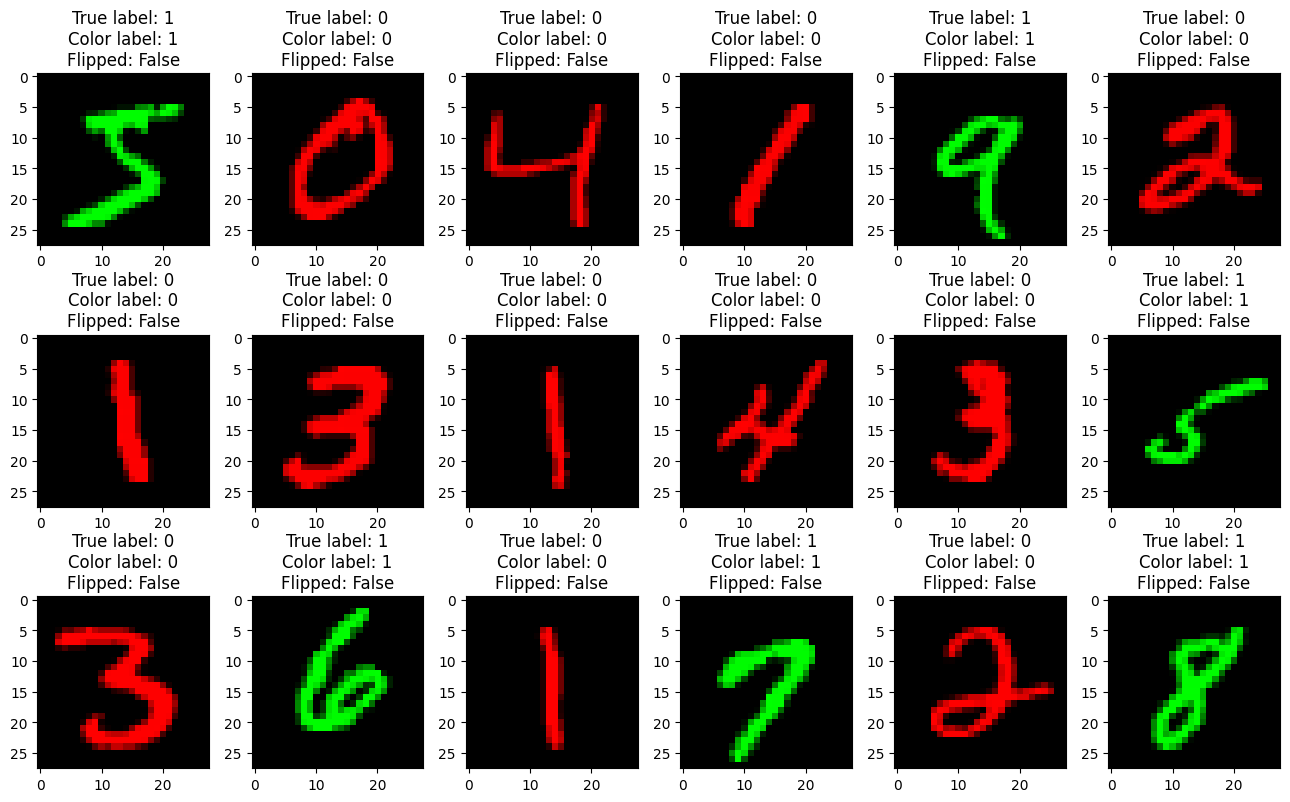

In [31]:
train_set = ColoredMNIST(root='./data',
                          env='train',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(train_set)

Colored MNIST dataset already exists


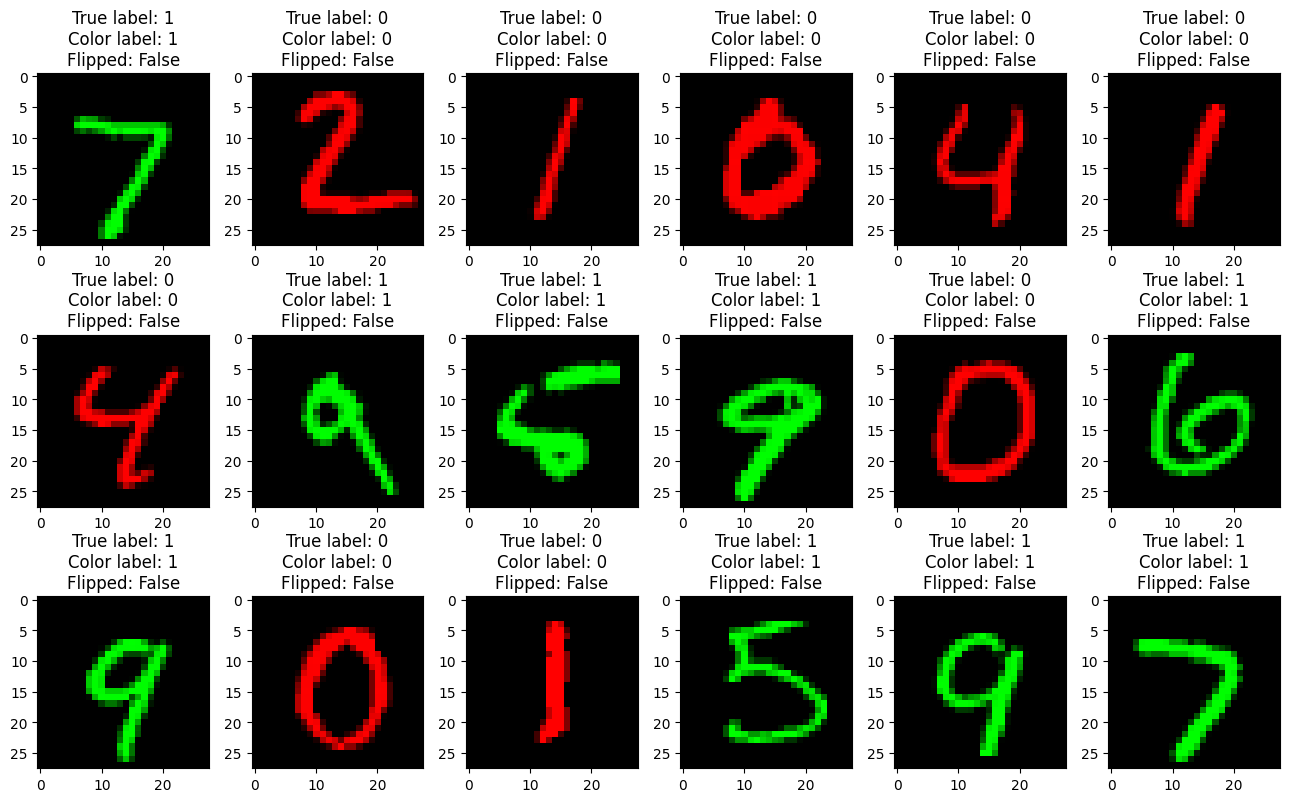

In [32]:
val_set = ColoredMNIST(root='./data',
                          env='val',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(val_set)

Colored MNIST dataset already exists


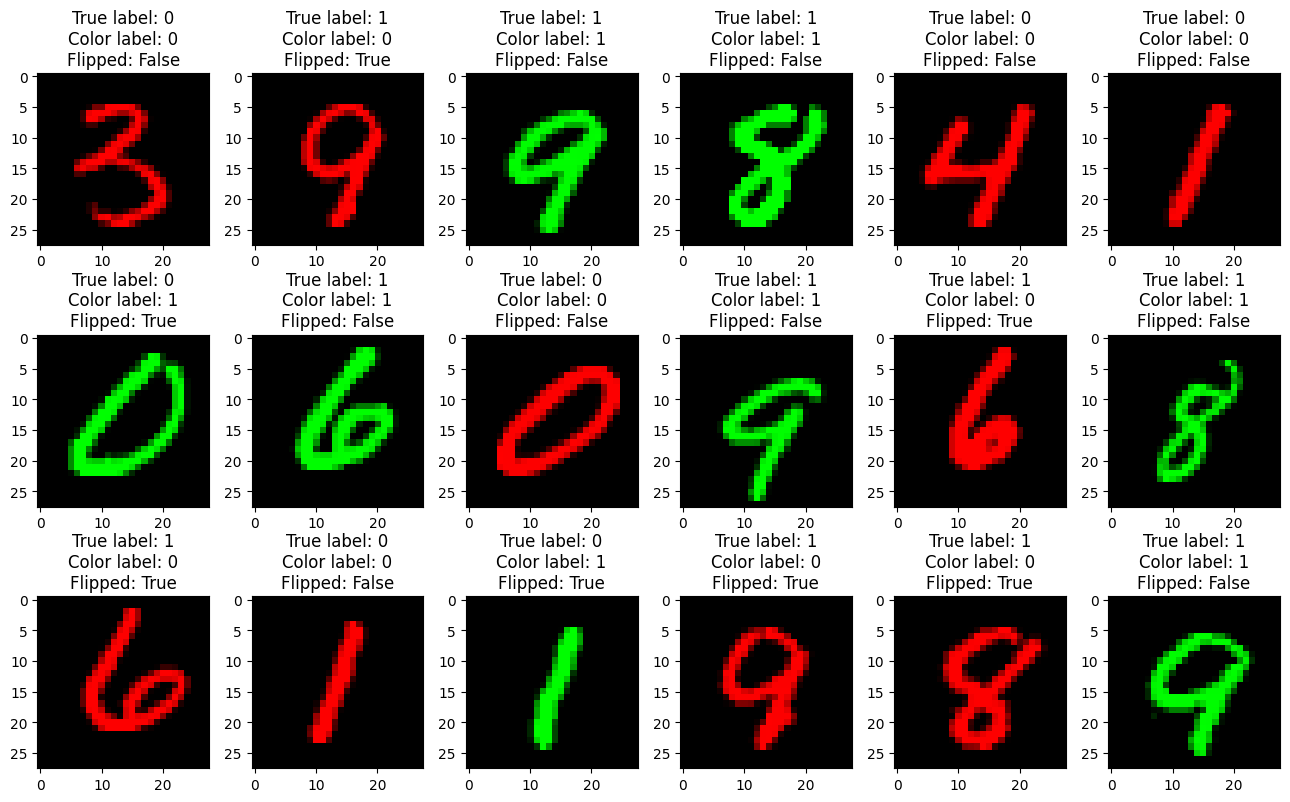

In [33]:
test_set = ColoredMNIST(root='./data',
                          env='test',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(test_set)

In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=10)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=10)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=10)

## Set device (For number crunching)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Initialize network

In [36]:
# Resnet50 transfer learning
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 2)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-2.0666e-02, -1.7833e-02, -6.8574e-04,  ...,  1.7123e-02,
          2.1879e-02,  7.2026e-03],
        [-2.1738e-03, -6.7009e-03,  1.6765e-02,  ..., -5.2075e-05,
          1.8750e-02,  1.6823e-02]], device='cuda:0', requires_grad=True)

## Train network

In [37]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train'          : {'loss' : [],
                                    'acc' : []},
                'validation'    : {'loss' : [],
                                    'acc' : []},
                'test'          : {'loss' : [],
                                    'acc' : []}}
        
    # epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # phase
        for phase in ['train', 'validation', 'test']:
            if phase == 'train':
                model.train()
                datasource = train_loader
            elif phase == "validation":
                model.eval()
                datasource = val_loader
            else:
                model.eval()
                datasource = test_loader

            epoch_loss = 0.0
            running_corrects = 0
            label_counter = 0

            # batch
            for inputs, true_lables, _ in datasource:
                inputs = inputs.to(device)
                true_lables = true_lables.to(device)
                
                logits = model(inputs)
                preds = logits.argmax(dim=1)
                running_corrects += torch.sum(preds == true_lables.data)
                label_counter += true_lables.size()[0]
                
                batch_loss = criterion(logits, true_lables)
                epoch_loss += batch_loss.item()

                if phase == 'train':
                    optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                    batch_loss.backward()   # compute gradients
                    optimizer.step()        # Performs a single optimization step (parameter update).
                
            epoch_acc = 100 * running_corrects.double() / label_counter
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.cpu())
            
    return model, history, inputs, true_lables, logits, batch_loss, label_counter

In [38]:
# F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
# https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
#criterion = F.binary_cross_entropy_with_logits #(input, target)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=.0001)

In [39]:
model, history, inputs, labels, preds, batch_loss, label_counter = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 97.2676, acc: 96.0617
validation loss: 3.5217, acc: 99.1400
test loss: 62.6045, acc: 50.1000
Epoch 2/10
----------
train loss: 31.3476, acc: 99.2233
validation loss: 1.9221, acc: 99.4400
test loss: 81.3275, acc: 50.3600
Epoch 3/10
----------
train loss: 20.4020, acc: 99.3733
validation loss: 1.3449, acc: 99.5200
test loss: 92.8296, acc: 50.4200
Epoch 4/10
----------
train loss: 15.7615, acc: 99.4517
validation loss: 1.0926, acc: 99.5400
test loss: 102.8859, acc: 50.5600
Epoch 5/10
----------
train loss: 13.1223, acc: 99.4983
validation loss: 0.8216, acc: 99.7400
test loss: 113.7214, acc: 50.3200
Epoch 6/10
----------
train loss: 11.1648, acc: 99.5483
validation loss: 0.7113, acc: 99.7600
test loss: 120.3028, acc: 50.4000
Epoch 7/10
----------
train loss: 9.4325, acc: 99.5983
validation loss: 0.6024, acc: 99.7400
test loss: 125.1357, acc: 50.3000
Epoch 8/10
----------
train loss: 8.5280, acc: 99.6467
validation loss: 0.5044, acc: 99.7800
test loss: 131.

## Assess performance

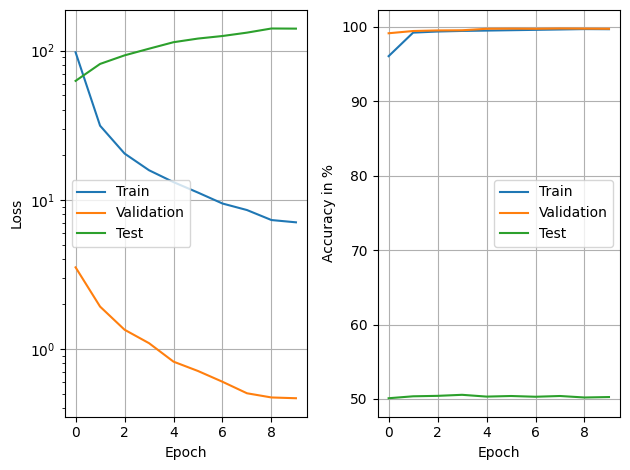

In [40]:
def plot_history(hist):
    """
    Plot the losses and accuracies during the training, validation and test procedures.
    """
    plt.subplot(1,2,1)
    plt.semilogy(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    plt.semilogy(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    plt.semilogy(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_history(history)

Why is the validation accuracy higher than the training accuracy?  

Answer, if a dropout layer is in use: (There is no dropout layer in resnet50)  
This is a typical behaviour when using dropout, since the behaviour during training and testing are different. When training, a percentage of the features are set to zero (50%, if dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Answer for this resnet50:  
Most probably, the training (50000 samples) and the validation (5000 samples) datasets are not 100% iid and there are some less complicated samples in the smaller dataset. Needs some analysis to confirm!

In [41]:
def random_tests(dataset):
    """
    Test and plot some digits from a provided colored MNIST dataset to be analyzed.
    """
    fig = plt.figure(figsize=(25,25))
    columns = 4
    rows = 8
    ax = []
    
    img, true_label, color_label = next(iter(dataset))
    model.eval()
    logits = model(img.to(device))
    pred = logits.argmax(dim=1)

    print("Batch accuracy: " + str(100 * torch.sum(pred == true_label.to(device)).item() / true_label.shape[0]) + "%")

    for i in range(columns*rows):
        ax.append(fig.add_subplot(8, 4, i + 1))
        if (pred[i].item() == true_label[i].item()):
            ax[-1].set_title("Ground truth: " + 
                             str(true_label[i].item()) + 
                             "\nPrediction: " + 
                             str(np.round(pred[i].item())) + 
                             "\nCorrect!")
        else:
            ax[-1].set_title("Ground truth: " + 
                             str(true_label[i].item()) + 
                             "\nPrediction: " + 
                             str(np.round(pred[i].item())) + 
                             "\nFooled!")
        plt.imshow(np.transpose(img[i].cpu().numpy(), (1,2,0)))
        
    plt.tight_layout()
    plt.show()

Batch accuracy: 100.0%


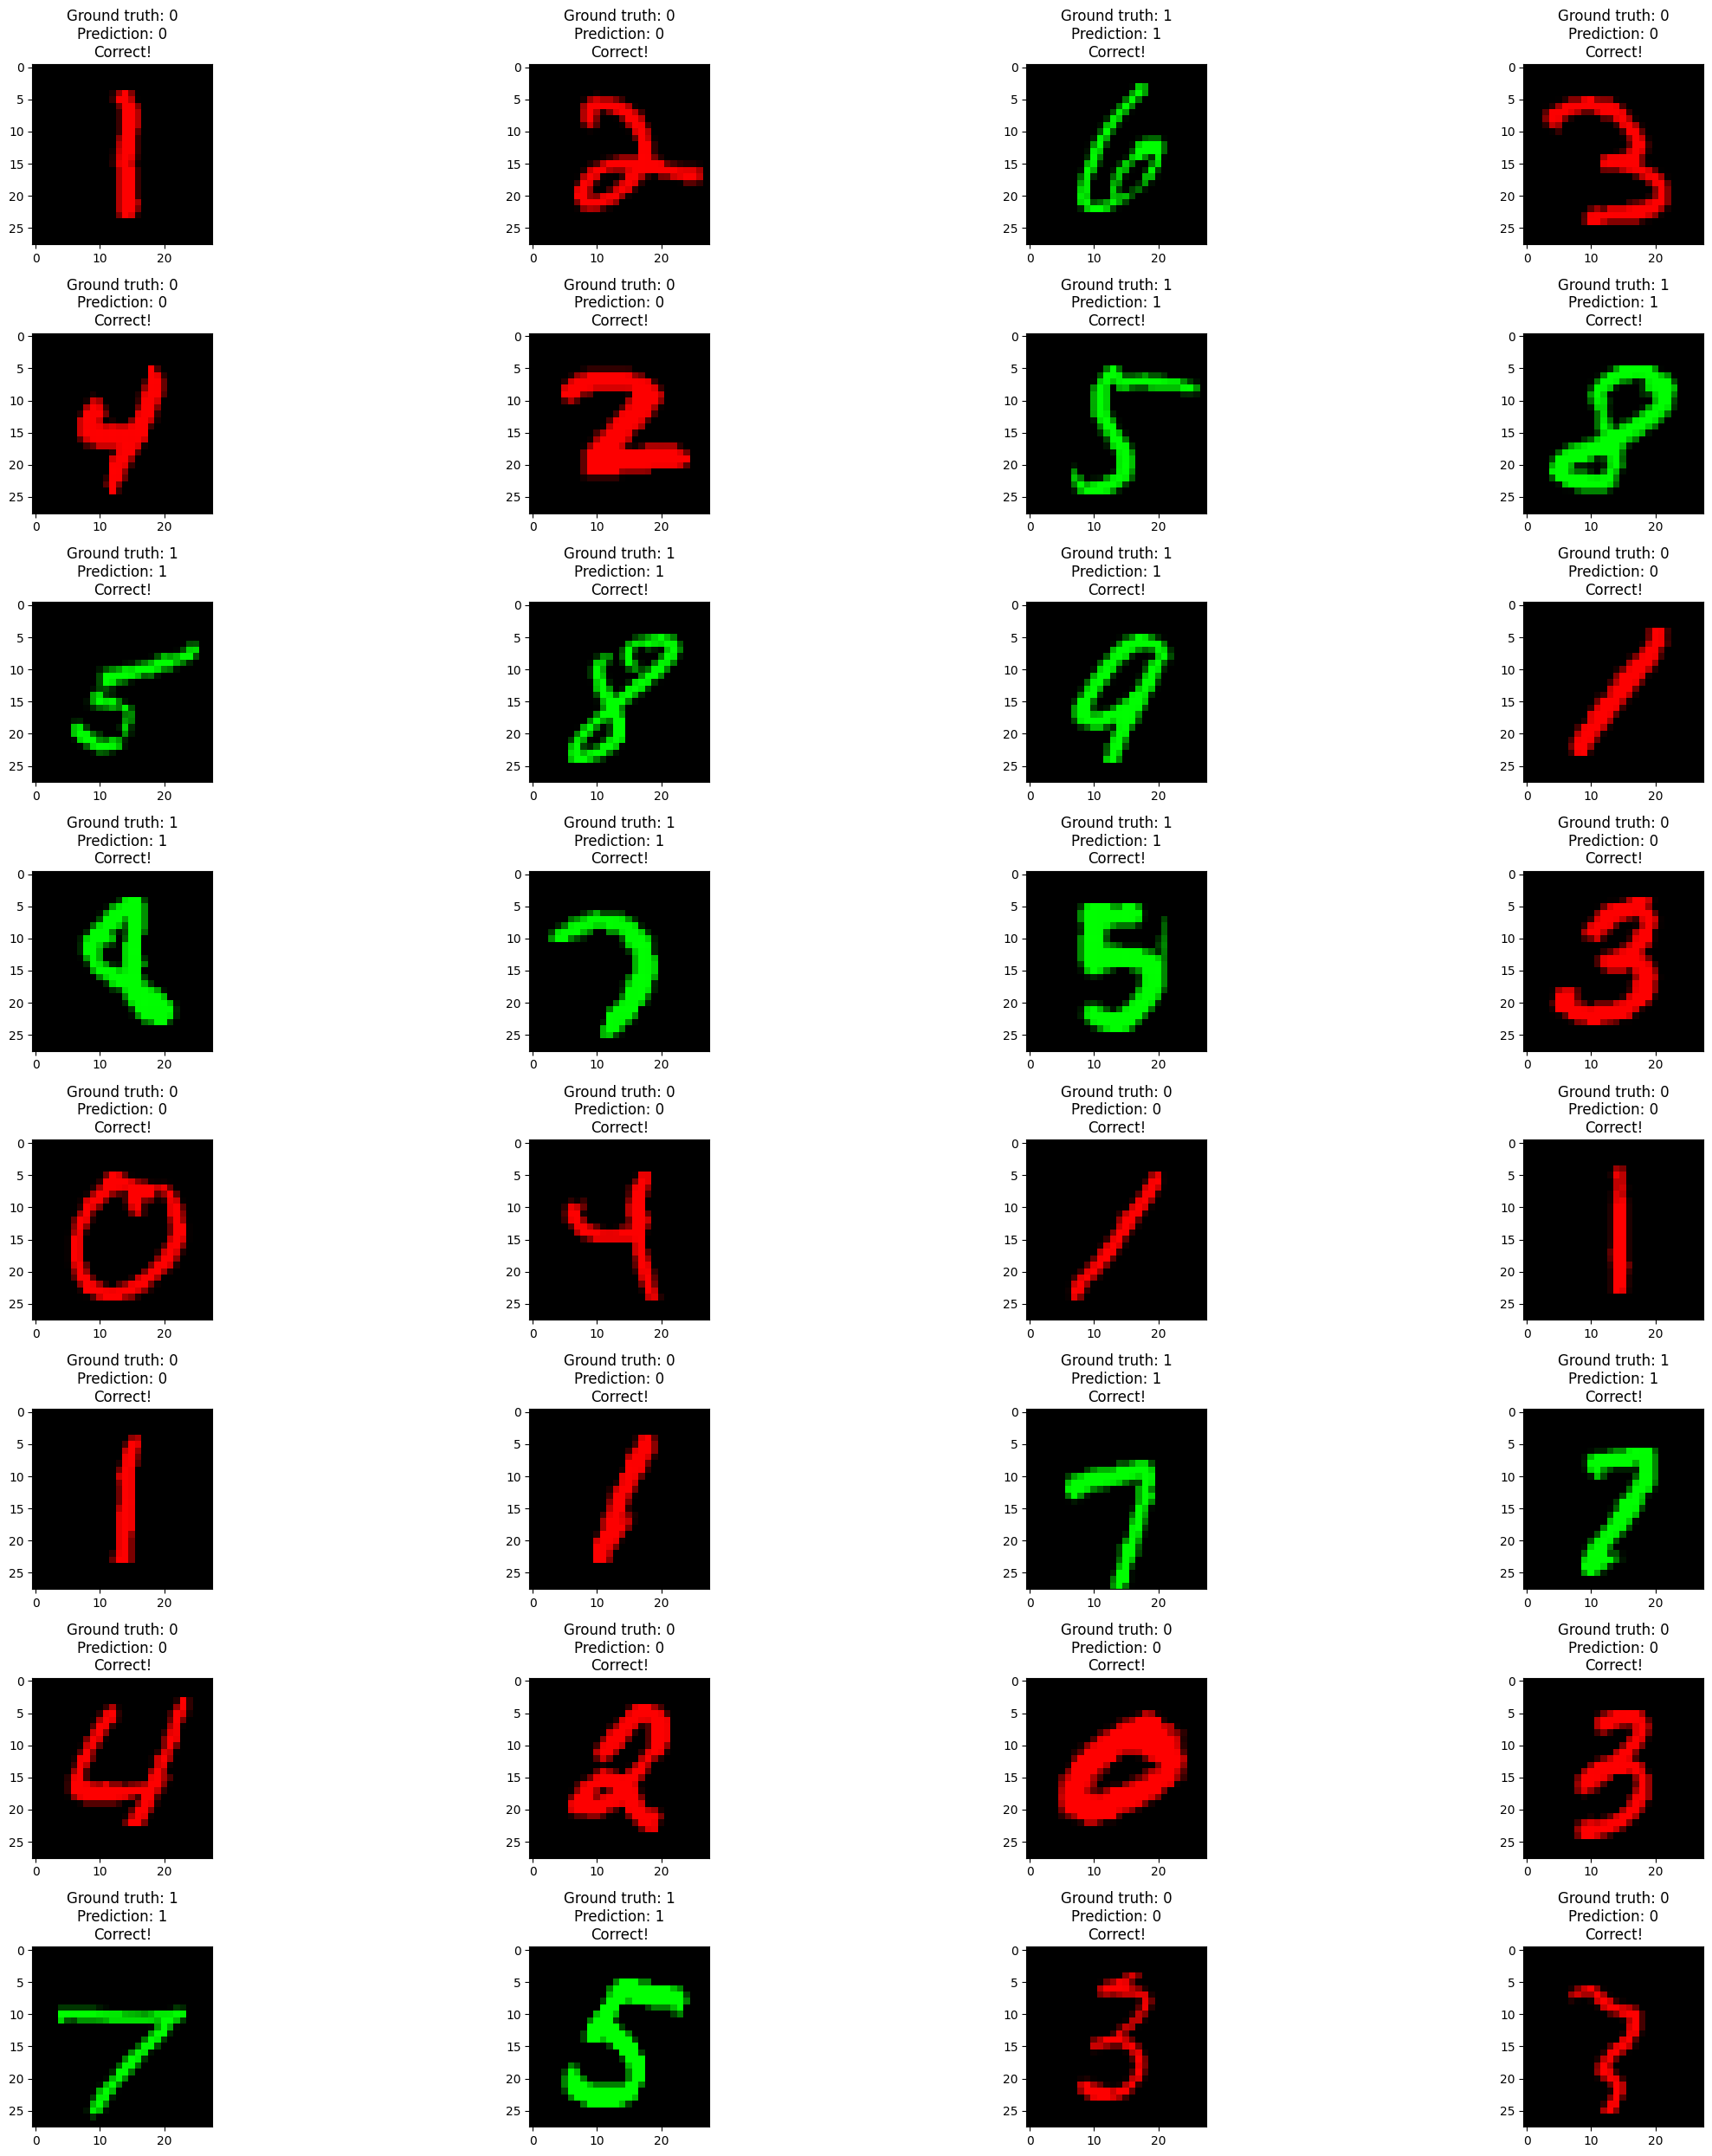

In [42]:
random_tests(train_loader)

Batch accuracy: 100.0%


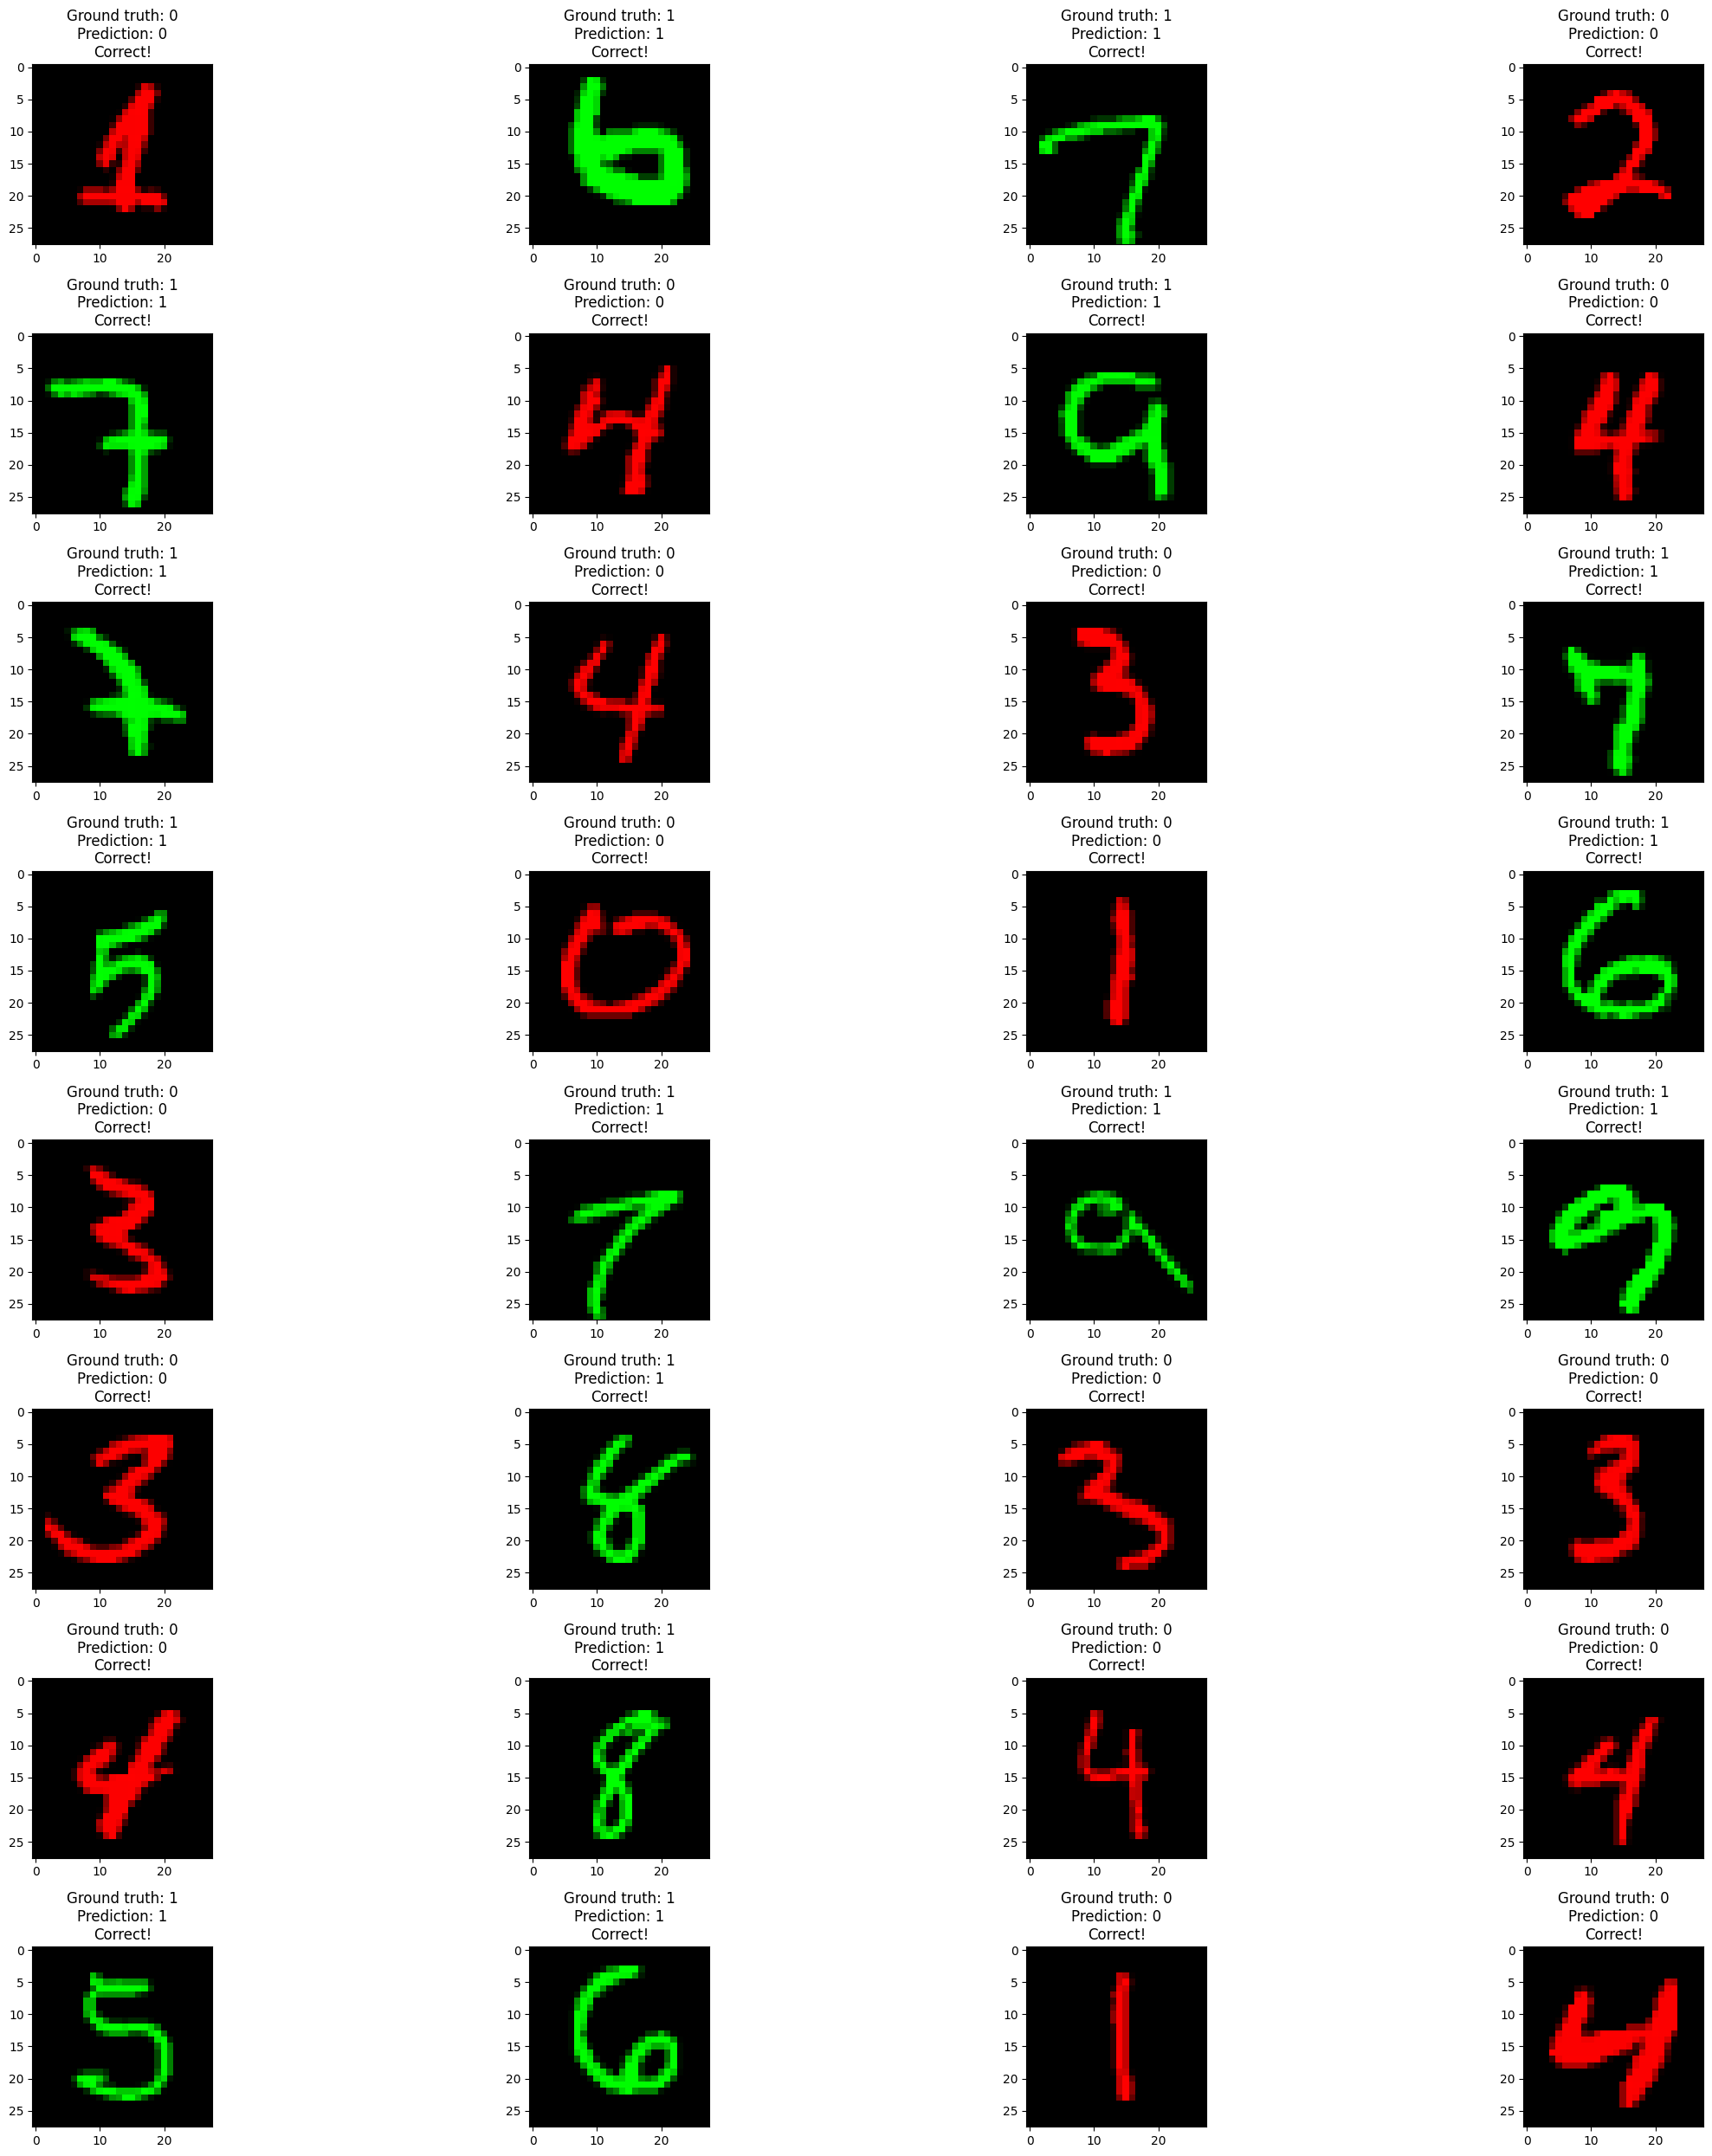

In [43]:
random_tests(val_loader)

Batch accuracy: 55.46875%


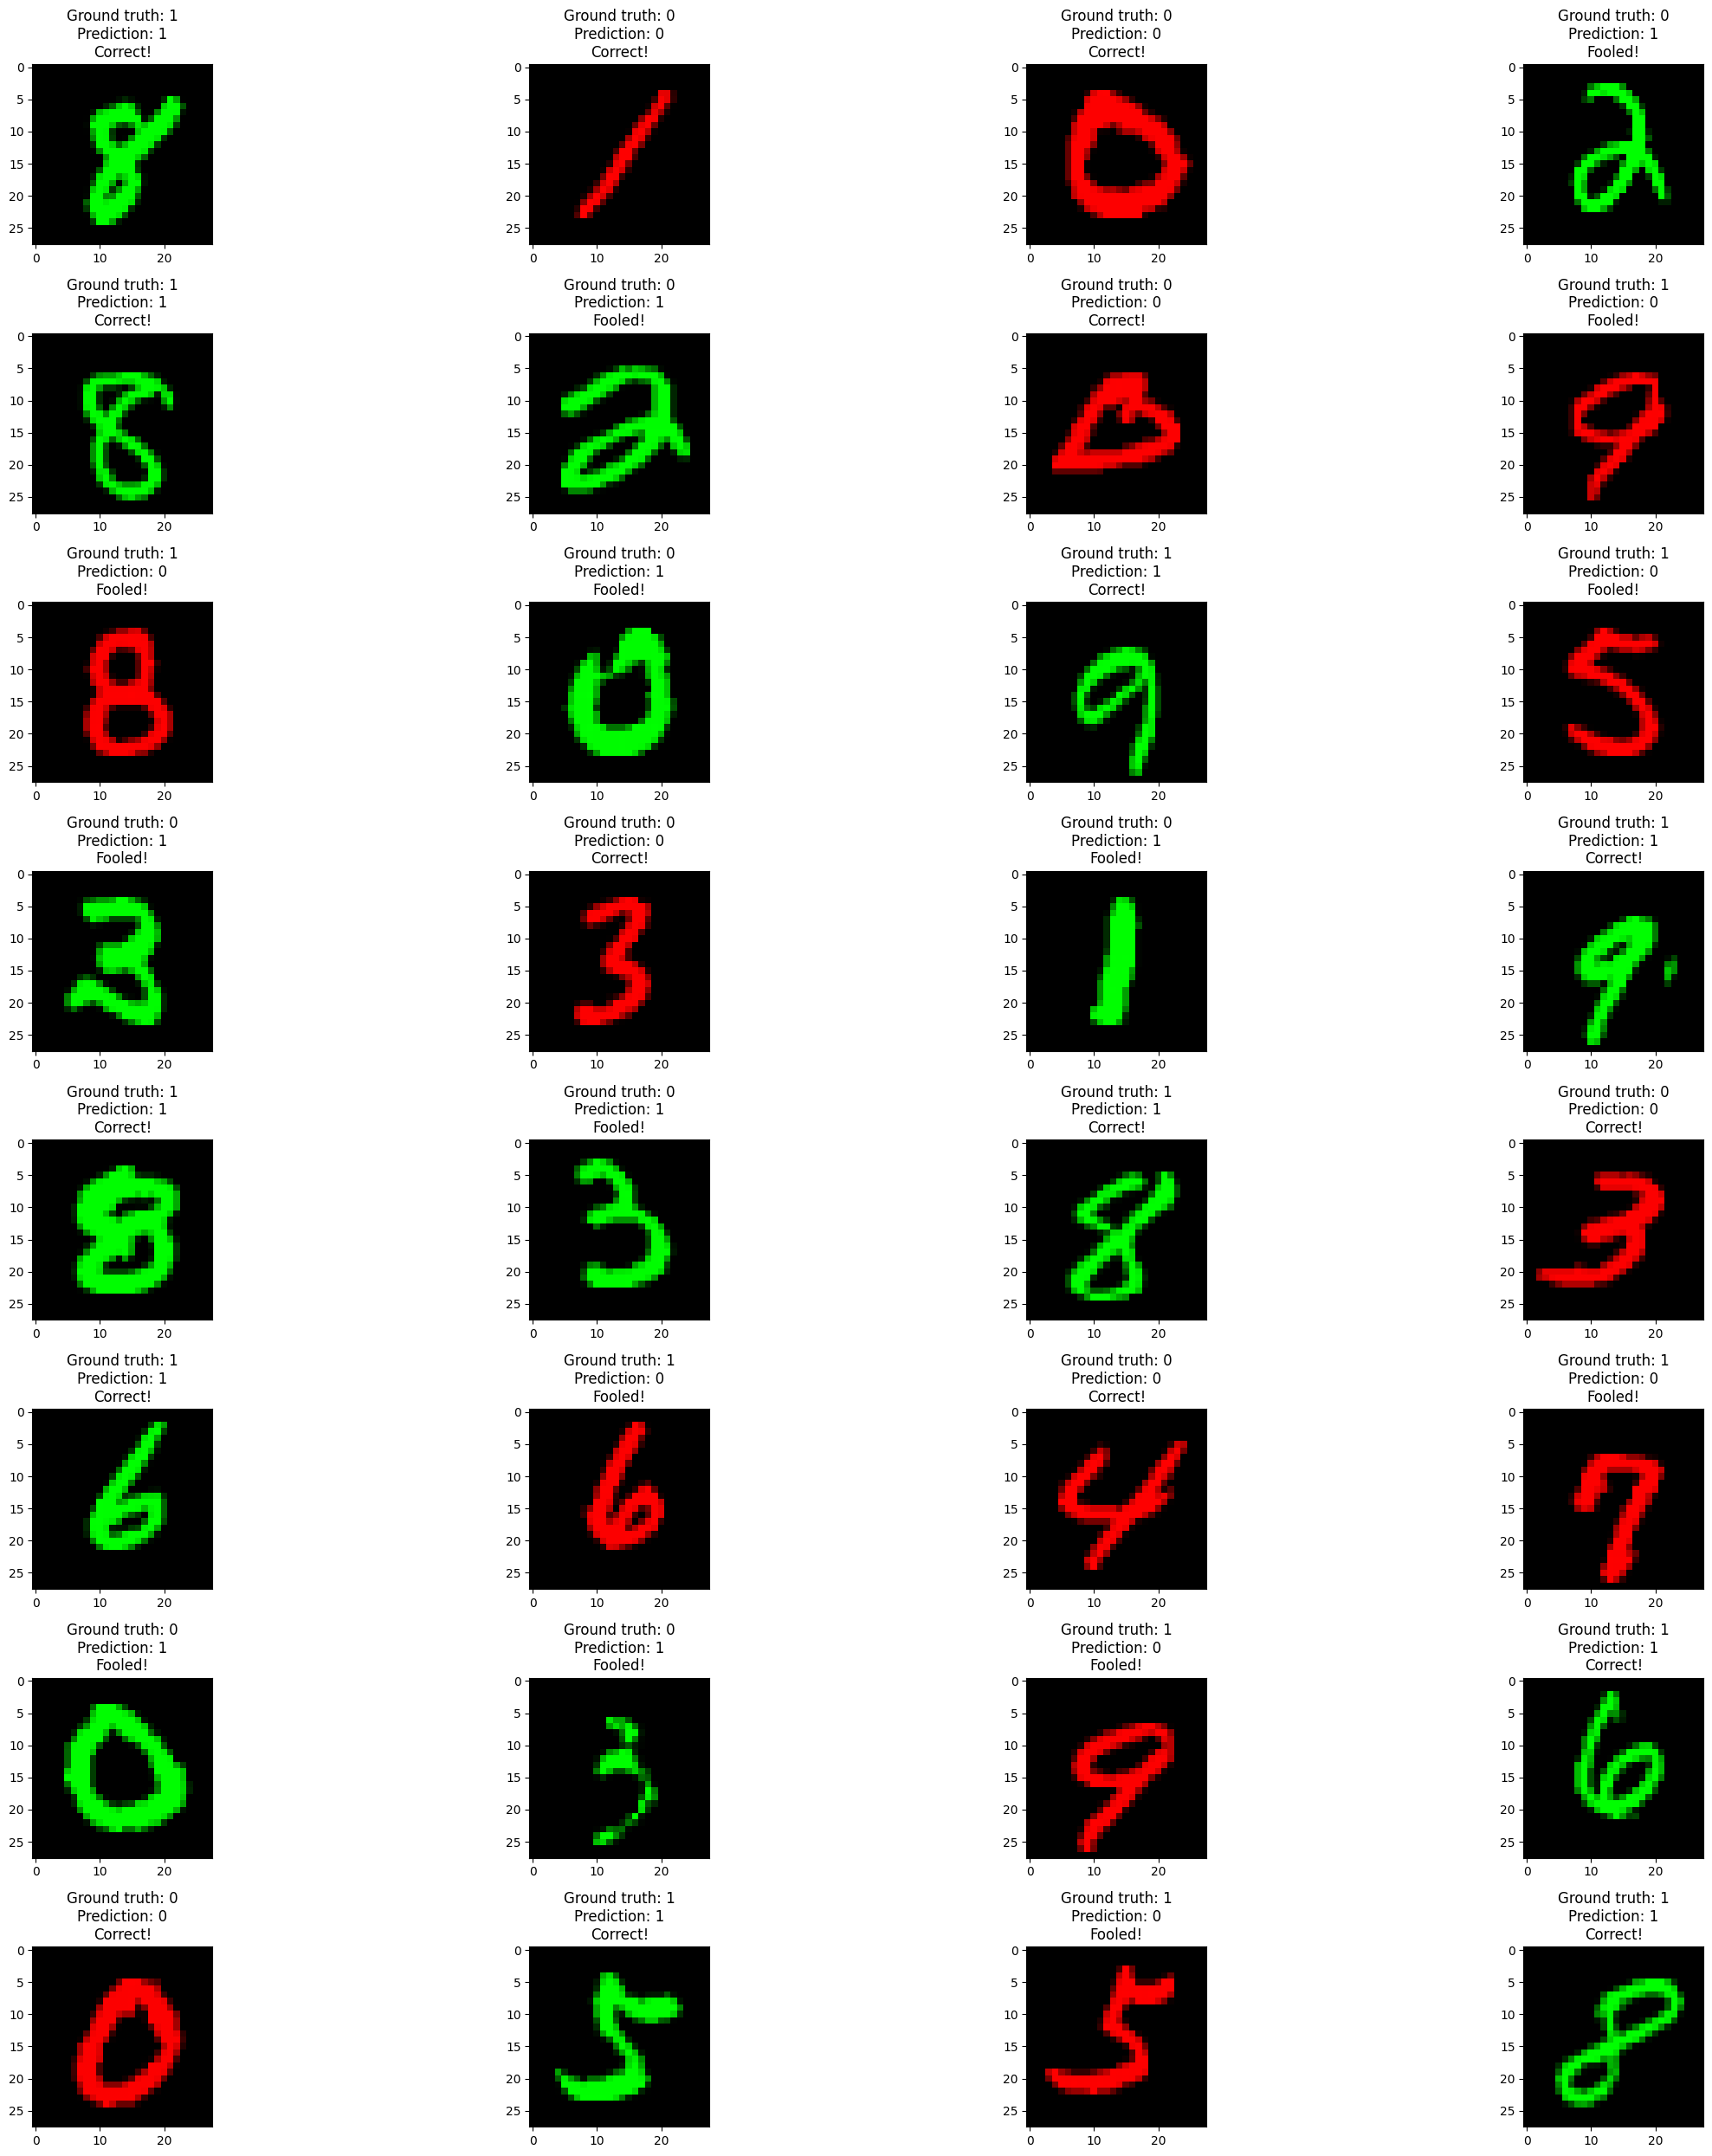

In [44]:
random_tests(test_loader)